In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)


def sigmoid(x):

    s = 1/(1+np.exp(-x))
    return s

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y

def load_extra_datasets():
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)

    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

In [4]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
X, Y = load_planar_dataset()

In [7]:
X.shape

(2, 400)

In [8]:
Y.shape

(1, 400)

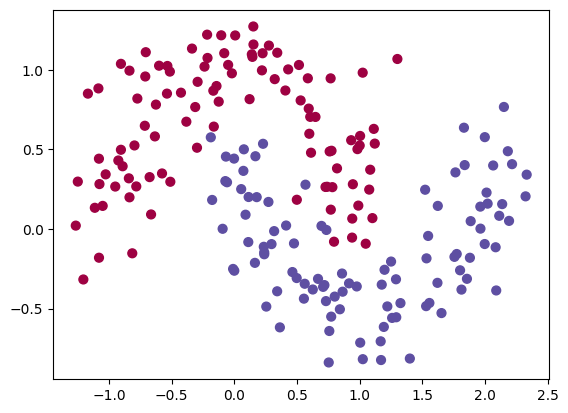

In [29]:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

In [30]:
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 200)
The shape of Y is: (1, 200)
I have m = 200 training examples!


In [31]:
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of logistic regression: 86 % (percentage of correctly labelled datapoints)


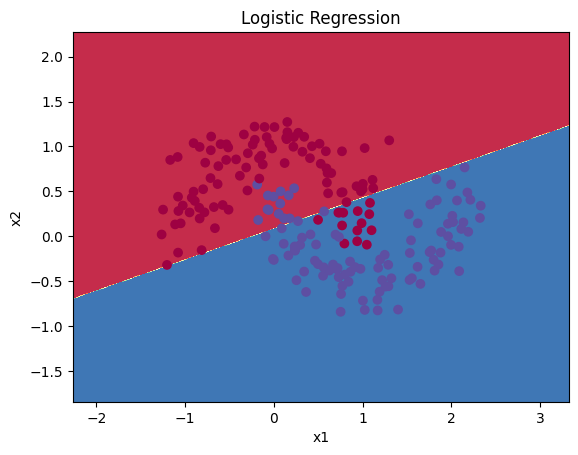

In [32]:
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

In [33]:
def layer_sizes(X, Y):

    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]

    return (n_x, n_h, n_y)

In [34]:
def initialize_parameters(n_x, n_h, n_y):

    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))


    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [35]:
def forward_propagation(X, parameters):

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]


    Z1 = np.dot(W1,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)


    assert(A2.shape == (1, X.shape[1]))

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, cache

In [36]:
def compute_cost(A2, Y):


    m = Y.shape[1] # number of examples


    logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1-A2),(1-Y))
    cost = - np.sum(logprobs)/m


    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect.
                                    # E.g., turns [[17]] into 17

    return cost

In [37]:
def backward_propagation(parameters, cache, X, Y):

    m = X.shape[1]


    W1 = parameters['W1']
    W2 = parameters['W2']


    A1 = cache['A1']
    A2 = cache['A2']

    dZ2 = A2 - Y
    dW2 = np.dot(dZ2,A1.T)/m
    db2 = np.sum(dZ2,axis=1,keepdims=True)/m
    dZ1 = np.dot(W2.T,dZ2) * (1 - np.power(A1, 2))
    dW1 = np.dot(dZ1,X.T)/m
    db1 = np.sum(dZ1,axis=1,keepdims=True)/m

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads

In [38]:
def update_parameters(parameters, grads, learning_rate = 1.2):

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']


    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']


    W1 = W1 - (learning_rate*dW1)
    b1 = b1 - (learning_rate*db1)
    W2 = W2 - (learning_rate*dW2)
    b2 = b2 - (learning_rate*db2)


    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [39]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):


    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]


    parameters = initialize_parameters(n_x, n_h, n_y)



    for i in range(0, num_iterations):


        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate = 1.2)


        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [40]:
def predict(parameters, X):

    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)


    return predictions

Cost after iteration 0: 0.693157
Cost after iteration 1000: 0.303407
Cost after iteration 2000: 0.044742
Cost after iteration 3000: 0.039118
Cost after iteration 4000: 0.037298
Cost after iteration 5000: 0.036261
Cost after iteration 6000: 0.035549
Cost after iteration 7000: 0.035011
Cost after iteration 8000: 0.034579
Cost after iteration 9000: 0.034220


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

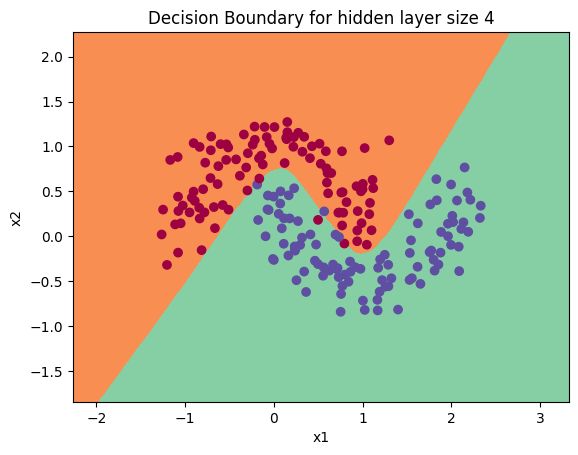

In [41]:
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [42]:
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 98%


Accuracy for 1 hidden units: 84.5 %
Accuracy for 2 hidden units: 85.5 %
Accuracy for 3 hidden units: 98.5 %
Accuracy for 4 hidden units: 98.5 %
Accuracy for 5 hidden units: 98.5 %


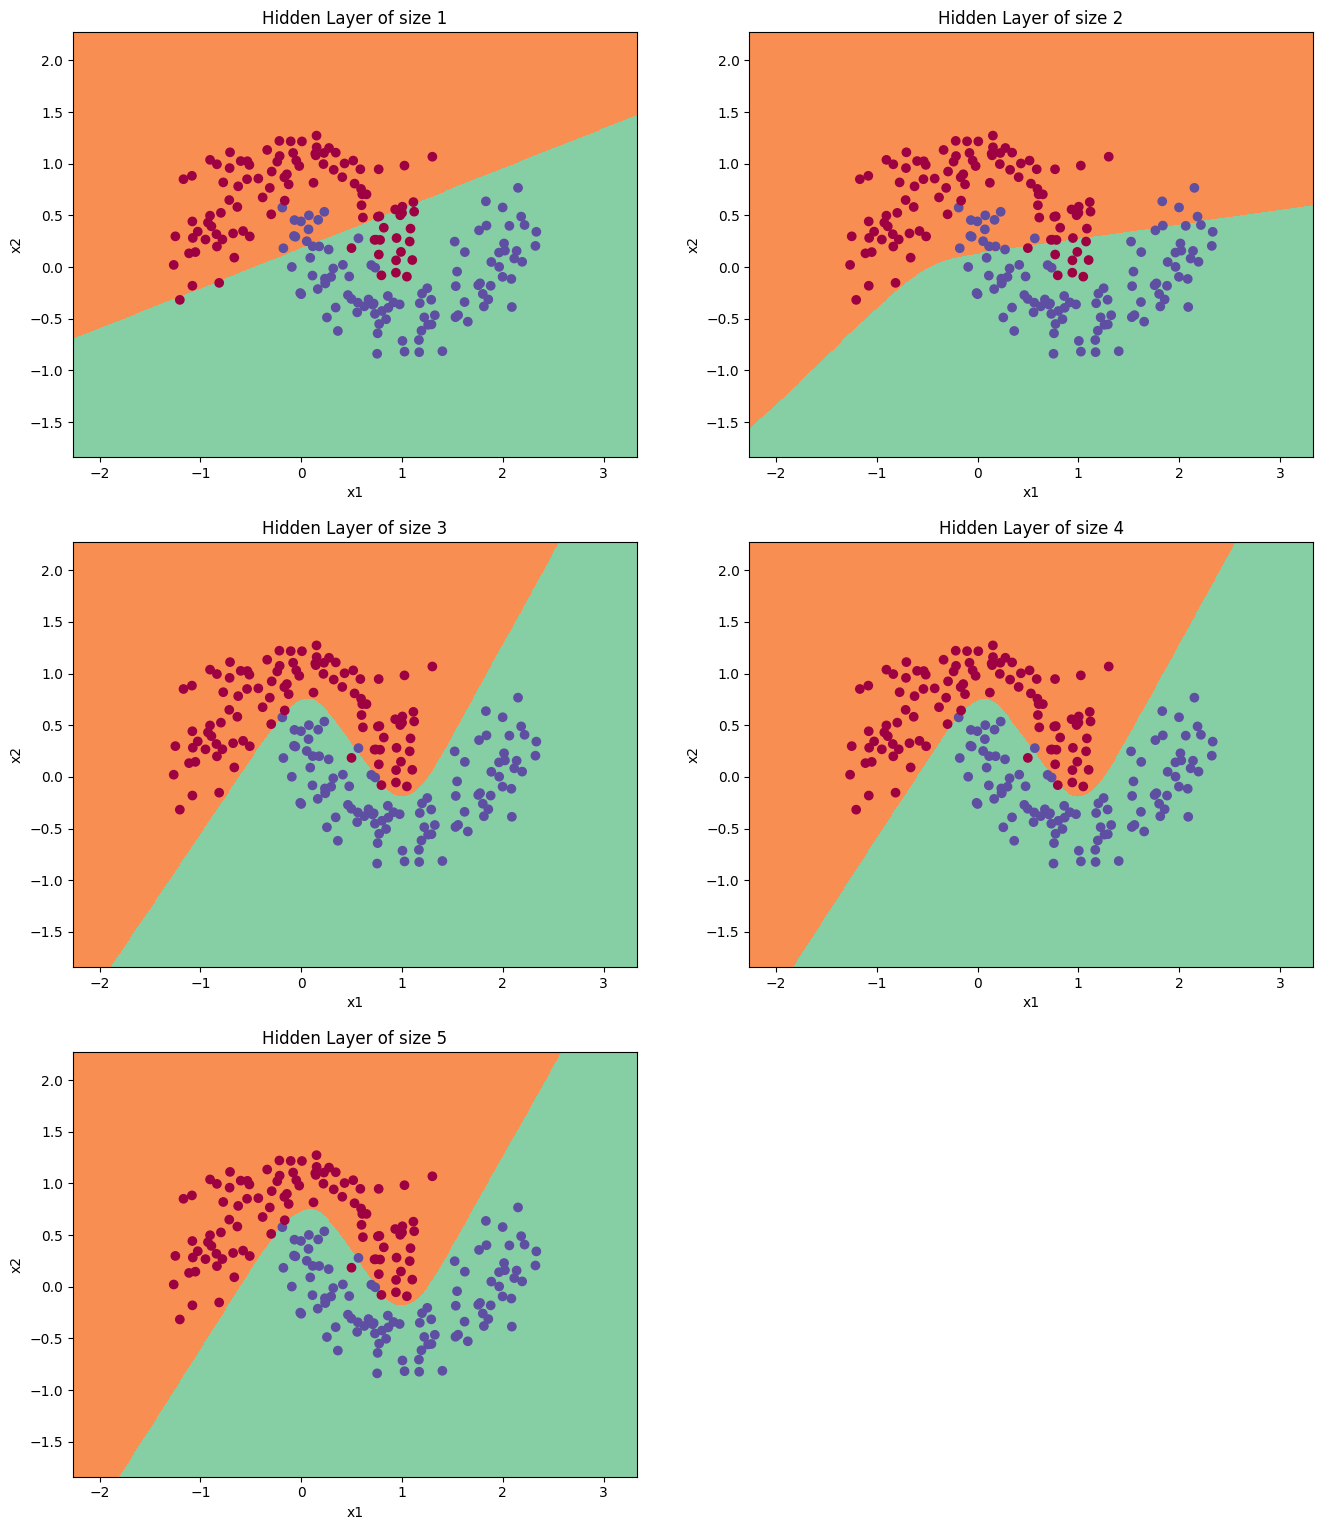

In [43]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5]

# you can try with different hidden layer sizes
# but make sure before you submit the assignment it is set as "hidden_layer_sizes = [1, 2, 3, 4, 5]"
# hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]

for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

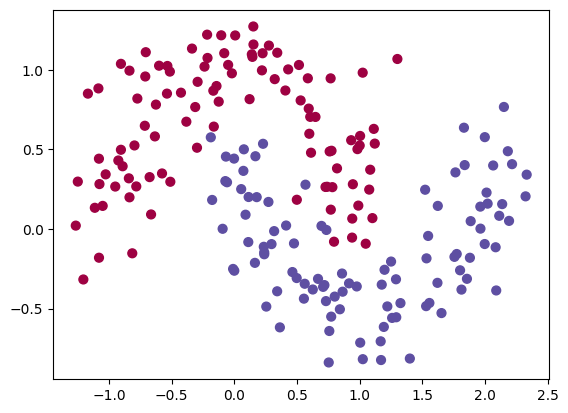

In [28]:
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "noisy_moons"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);